### Foreward

In this notebook I do an evaluation of the results. 

**Organisation**

I have moved most of the code into sepeate python files. This was to prioritise readibility of the Notebook.

**Structure**

The notebook is ordered as follows:
1. Generate a dataframe `metrics_df` that is a table that contains summary statistics that are discussed.
2. Performance Evalution
    1. High level comparison of metrics
    2. Comparison of metrics across different projects
3. Error Investigation

**Clarification on terminology**

1. Ground truth nodes refers to a set of nodes (steps of a process) that were annotated by hand
2. Generated nodes refers to a set of nodes (steps of a proces) that were generated by an LLM

In [9]:
import os
import pandas as pd

from rich import print as rprint
from dotenv import load_dotenv

from langchain_openai import AzureOpenAIEmbeddings

import matplotlib.pyplot as plt

from plotting_utils import render_graph
from caching import retrieve_cache, dump_cache
from evaluation_functions import calculate_node_metrics, calculate_node_metrics_semantic

pd.set_option('display.max_colwidth', None)
load_dotenv('.env')

True

In [10]:
requirements_df = pd.read_csv('../data/requirements.csv')
generations_df = pd.read_csv("../data/generated_graphs.csv")
ground_truth_df = pd.read_csv('../data/annotations.csv')
project_ids = ground_truth_df['ProjectID'].unique().tolist()
project_ids

[35, 34, 19, 36]

In [11]:
ground_truth_df.head()

,from_node,to_node,ProjectID
0,Start,Display Logo and Basic Design,35
1,Display Logo and Basic Design,Attractive Design According to Clients,35
2,Attractive Design According to Clients,Comfortable User Experience,35
3,Comfortable User Experience,Reflect Seriousness of Environment,35
4,Reflect Seriousness of Environment,Manage Information from Database and Catalogue,35


In [12]:
generations_df.head()

,ProjectID,from_node,to_node
0,35,Start,Display Logo and Basic Design
1,35,Display Logo and Basic Design,Attractive Design and Color
2,35,Attractive Design and Color,Comfortable User Experience
3,35,Attractive Design and Color,Reflect Seriousness of Environment
4,35,Display Logo and Basic Design,Manage Incoming Information


### 1. Generate Metrics Table
Generate a table that summarises the performance of the proposed approach.

Two sets of metrics are generated. 

The first set is the set that only considers two nodes as matching when they are the same character-for-character. 

The second set is the set where we consider semantic matches as acceptible as well, and we use an embedding model to do the semantic matching.

A very basic cache is used to store embeddings. This is to speed up the comparison operations.

In [13]:
embedding_function = AzureOpenAIEmbeddings(          
            openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
            deployment=os.getenv('EMBEDDING_DEPLOYMENT_NAME'),
            model='text-embedding-ada-002',
            openai_api_version=os.getenv('AZURE_OPENAI_VERSION'),
            azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
            chunk_size=1) 

embedding_function = embedding_function.embed_query

In [14]:
columns = ['ProjectID', 'TP', 'FP', 'FN', 'TP with Semantic', 'FP with Semantic', 'FN with Semantic']
metrics_df = pd.DataFrame(columns=columns)
cache = retrieve_cache()

for project_id in project_ids:

    results = {'ProjectID': project_id, 'TP': 0, 'FP': 0, 'FN': 0, 'TP with Semantic': 0, 'FP with Semantic': 0, 'FN with Semantic': 0}

    #retrieve the ground truth and generated nodes to compare against each other
    generated_nodes = generations_df.loc[generations_df['ProjectID']==project_id, ['from_node', 'to_node']].values.tolist()
    ground_truth_nodes = ground_truth_df.loc[ground_truth_df['ProjectID']==project_id, ['from_node', 'to_node']].values.tolist()

    #calculate TP, FP, FN for each project WITHOUT semantic comparison
    results['TP'], results['FP'], results['FN'], results['FP Nodes'], results['FN Nodes'] = calculate_node_metrics(ground_truth_nodes, generated_nodes)

    #calculate TP, FP, FN for each project WITH semantic comparison
    results['TP with Semantic'], results['FP with Semantic'], results['FN with Semantic'], results['FP with semenatic Nodes'], results['FN with semantic Nodes'], cache = calculate_node_metrics_semantic(ground_truth_nodes, generated_nodes, embedding_function, cache)

    #append all data to metric df
    metrics_df = pd.concat((metrics_df, pd.DataFrame([results])), axis = 0)

    dump_cache(cache)

#add some additional useful columns
metrics_df = metrics_df.reset_index(drop=True)
metrics_df['TP% with Semantic'] = metrics_df['TP with Semantic']/(metrics_df['TP with Semantic'] + metrics_df['FP with Semantic'] + metrics_df['FN with Semantic'])
metrics_df['FP% with Semantic'] = metrics_df['FP with Semantic']/(metrics_df['TP with Semantic'] + metrics_df['FP with Semantic'] + metrics_df['FN with Semantic'])
metrics_df['FN% with Semantic'] = metrics_df['FN with Semantic']/(metrics_df['TP with Semantic'] + metrics_df['FP with Semantic'] + metrics_df['FN with Semantic'])
metrics_df['TP%'] = metrics_df['TP']/(metrics_df['TP'] + metrics_df['FP'] + metrics_df['FN'])
metrics_df['FP%'] = metrics_df['FP']/(metrics_df['TP'] + metrics_df['FP'] + metrics_df['FN'])
metrics_df['FN%'] = metrics_df['FN']/(metrics_df['TP'] + metrics_df['FP'] + metrics_df['FN'])

Loaded cache from disk


In [15]:
metrics_df[['ProjectID', 'TP%', 'FP%', 'FN%', 'TP% with Semantic', 'FP% with Semantic', 'FN% with Semantic']]

,ProjectID,TP%,FP%,FN%,TP% with Semantic,FP% with Semantic,FN% with Semantic
0,35,0.178571,0.428571,0.392857,1.0,0.0,0.0
1,34,0.151515,0.363636,0.484848,1.0,0.0,0.0
2,19,0.038462,0.5,0.461538,1.0,0.0,0.0
3,36,0.069767,0.534884,0.395349,1.0,0.0,0.0


### 2. Performance Analysis
The performance metrics are considered across all projects combined to get an aggregate view of performance, and on a per-project basis to uncover possible issues with the system. 

The performance metrics chosen are the number of True Positives,  False Positives, False Negatives. Another metric such as F1 could also be used, but for simplicicity this is not considered in this work.

The number of false positives is the number of nodes in the generated graph that do not exist in the ground truth graph. The false positives are an indication of the number nodes that the LLM creates that are not in the ground truth, and are possibly hallucinations. If this number is high, it means that the LLM is creating nodes in the graph that shouldn't be there.

The number of false negatives is the number of nodes that are in the ground truth but are not found in the graph generated by the LLM. This is an indication of the LLM's ability to completely capture all of the SRS requirements into a workflow. If this number is high, it possibly indicates that the LLM could not make complete sense of the SRS requirements to generate a complete graph. 

The calculations of these metrics are considered in two cases. 
1. The first case is where I calculate the metrics using exact matches on the node names; i.e., the node names must match character for character.
2. The second case is where I calculate the metrics using semantic similarity. In this case Sklearn's cosine similarity score is used to compare semantic meaning of the node names, by using an embedding model. 

#### 2.1 Overall Performance
First the metrics are considered by aggregrating across projects to get a genral idea of the performance.

In [16]:
print("Metrics (non-semantic):")
print(f"""
True Positives:  {metrics_df['TP'].sum()} ({metrics_df['TP%'].mean()*100:.1f}%)
False Positives: {metrics_df['FP'].sum()} ({metrics_df['FP%'].mean()*100:.1f}%)
False Negatives: {metrics_df['FN'].sum()} ({metrics_df['FN%'].mean()*100:.1f}%)
      """)

print("Metrics (with semantic):")
print(f"""
True Positives:  {metrics_df['TP with Semantic'].sum()} ({metrics_df['TP% with Semantic'].mean()*100:.1f}%)
False Positives: {metrics_df['FP with Semantic'].sum()} ({metrics_df['FP% with Semantic'].mean()*100:.1f}%)
False Negatives: {metrics_df['FN with Semantic'].sum()} ({metrics_df['FN% with Semantic'].mean()*100:.1f}%)
      """)

Metrics (non-semantic):

True Positives:  14 (11.0%)
False Positives: 60 (45.7%)
False Negatives: 56 (43.4%)
      
Metrics (with semantic):

True Positives:  74 (100.0%)
False Positives: 0 (0.0%)
False Negatives: 0 (0.0%)
      


**Overall Performance Analysis** 

Overall it is clear that by comparing the nodes using their semantic meaning (with embeddings) is a huge improvement and this is the way that should be followed when comparing the ground truth to the generated graphs.

#### 2.2 Individual Project Performance

Next the performance is considered on a per-project level to understand the performance more deeply.

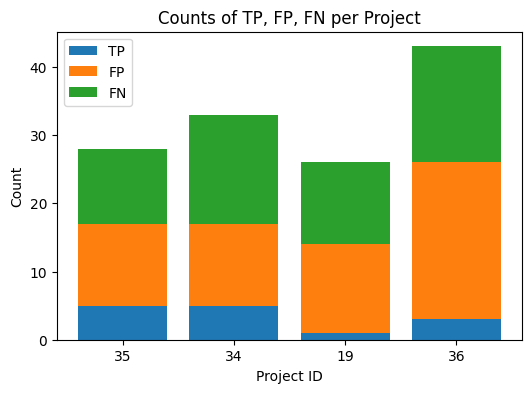

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))

# Plot each metric
ax.bar(metrics_df.index, metrics_df['TP'], label='TP')
ax.bar(metrics_df.index, metrics_df['FP'], bottom=metrics_df['TP'], label='FP')
ax.bar(metrics_df.index, metrics_df['FN'], bottom=metrics_df['TP'] + metrics_df['FP'], label='FN')

# Customize the plot
ax.set_title('Counts of TP, FP, FN per Project')
ax.set_xlabel('Project ID')
ax.set_ylabel('Count')
ax.set_xticks(metrics_df.index)
ax.set_xticklabels(metrics_df['ProjectID'])
ax.legend()

plt.show()

**Analysis - Without Semantic Comparison** 

This chart shows the number of True Positives, the number of False Positives, and the number False Negatives for each of the projects without comparing the semantic meaning of each of the nodes. Most of the projects have significantly low True Positives, which proves that comparing the node names word for word is not optimal. 

Below the graph for project 35 is shown to compare the hand annotated graph against the generated graph.

In [33]:
#retrieve the ground truth and generated nodes to compare against each other
project_id = 35
ground_truth_nodes = ground_truth_df.loc[ground_truth_df['ProjectID'] == project_id][['from_node', 'to_node']].values.tolist()
generated_nodes = generations_df.loc[generations_df['ProjectID'] == project_id][['from_node', 'to_node']].values.tolist()

In [34]:
print("Project 35 Ground Truth Graph")
render_graph(ground_truth_nodes)

Project 35 Ground Truth Graph


Project 35 Generated Graph


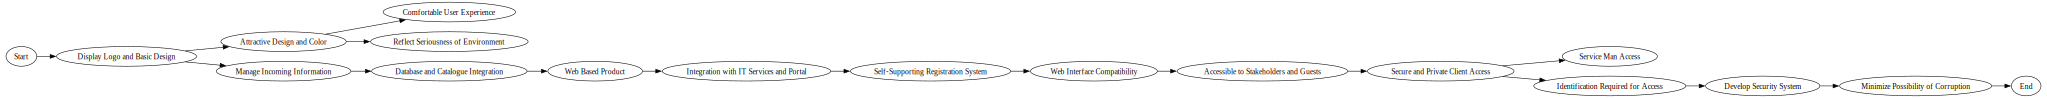

In [35]:
print("Project 35 Generated Graph")
render_graph(generated_nodes)

**Analysis of Project 35**

Two things are observed:
1. The false positives are attributed differences in naming convention ('End' vs 'End_Security System Implemented')
2. The false negatives are attributed to some missing nodes in the graph generated by the LLM. A possible reason for this is that not enough context is provided in the requirements data. This point is expounded in later paragraphs.

Next, we do the same analysis, but this time with semantic matching between the nodes with an embedding model.

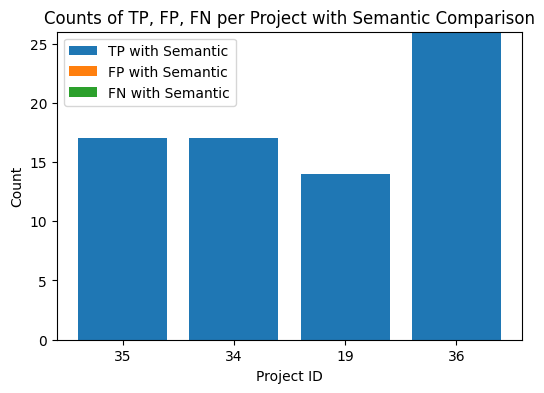

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))

# Plot each metric
ax.bar(metrics_df.index, metrics_df['TP with Semantic'], label='TP with Semantic')
ax.bar(metrics_df.index, metrics_df['FP with Semantic'], bottom=metrics_df['TP with Semantic'], label='FP with Semantic')
ax.bar(metrics_df.index, metrics_df['FN with Semantic'], bottom=metrics_df['TP with Semantic'] + metrics_df['FP with Semantic'], label='FN with Semantic')

# Customize the plot
ax.set_title('Counts of TP, FP, FN per Project with Semantic Comparison')
ax.set_xlabel('Project ID')
ax.set_ylabel('Count')
ax.set_xticks(metrics_df.index)
ax.set_xticklabels(metrics_df['ProjectID'])
ax.legend()

plt.show()

**Analysis - With Semantic Matching** 

In the above chart, we can see that the number of True Positives is significantly better when using semantic comparison of the nodes. 

### 3. Error Investigation
So far this notebook presented high level information on the false positives and false negatives. 

In this section we look at a few more examples to see if there are any other reasons for why there are differences between the ground truth and generated data.

We look at two more projects and discuss reasons for why there are false negatives/false postives

In [37]:
project_id = 19
ground_truth_nodes = ground_truth_df.loc[ground_truth_df['ProjectID'] == project_id][['from_node', 'to_node']].values.tolist()
generated_nodes = generations_df.loc[generations_df['ProjectID'] == project_id][['from_node', 'to_node']].values.tolist()

In [38]:
reqs = " ".join(requirements_df.loc[requirements_df['ProjectID'] == project_id]['RequirementText'].tolist())
rprint(f"[bold]Requirements of project {project_id}:[/bold] \n{reqs}")

Requirements of project 19: 
The system must be easy to use by both managers and chefs such that they do not need to read an extensive amount of
manuals. The system must be quickly accessible by both managers and chefs. The system must be intuitive and simple 
in the way it displays all relevant data and relationships. The menus of the system must be easily navigable by the
users with buttons that are easy to understand. All the functions of the system must be available to the user every
time the system is turned on. The calculations performed by the system must comply according to the norms set by 
the user and should not vary unless explicitly changed by the user. The client should agree to EULA before using 
our software.

Project 19 Ground Truth:


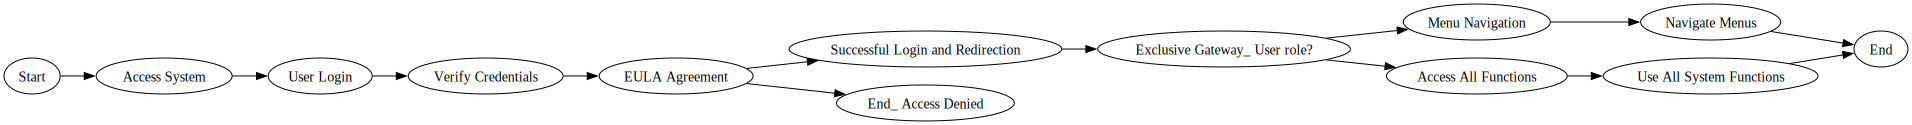

In [39]:
print(f"Project {project_id} Ground Truth:")
render_graph(ground_truth_nodes)

Project 19 Generated Graph:


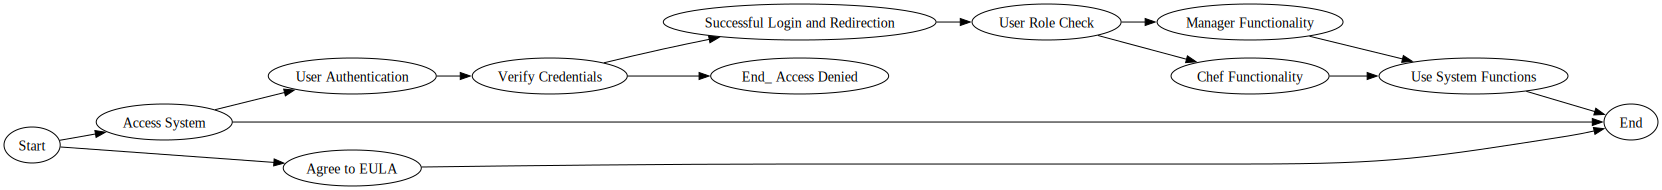

In [40]:
print(f"Project {project_id} Generated Graph:")
render_graph(generated_nodes)

#### Analysis:
**Observation** - A major concern in developing this solution is the quality of the description of the System Requirements from which the graphs are generated. In this example, there are requirements of what the system should/should not do, but is quite difficult to envisage what this system is from this set of requirements. If it is difficult for a human to understand what the system actually does, it similarly may be difficult for an LLM to understand what the system does. Because the systems are not explicitly described, the LLM has some leeway on how to interpret the requirements when it generates the graph. 

**Suggested Resolution** - the System Requirements that are used to generate the graph need to be subjected to some standards to ensure that they adequately describe the system. This could including an additional paragraph that describes background to the system, or describes the problem that the system solves. Providing that context will make the hand-annotation and LLM generation of the graphs much more informed and meaningful. 

Lets look at another project for further insights.

In [41]:
project_id = 34
ground_truth_nodes = ground_truth_df.loc[ground_truth_df['ProjectID'] == project_id][['from_node', 'to_node']].values.tolist()
generated_nodes = generations_df.loc[generations_df['ProjectID'] == project_id][['from_node', 'to_node']].values.tolist()

In [42]:
reqs = " ".join(requirements_df.loc[requirements_df['ProjectID'] == project_id]['RequirementText'].tolist())
rprint(f"[bold]Requirements of project {project_id}:[/bold] \n{reqs}")

Requirements of project 34: 
The system use SSL (secured socket layer) in all transactions that include any confidential customer information. 
The system must automatically log out all customers after a period of inactivity. The system should not leave any 
cookies on the customer's computer containing the user's password. The system's back-end servers shall only be 
accessible to authenticated administrators. Sensitive data will be encrypted before being sent over insecure 
connections like the internet. The system provides storage of all databases on redundant computers with automatic 
switchover. The reliability of the overall program depends on the reliability of the separate components. The main 
pillar of reliability of the system is the backup of the database which is continuously maintained and updated to 
reflect the most recent changes. An end-user may use this system on any OS; either it is Windows or Linux.

Project 34 Ground Truth:


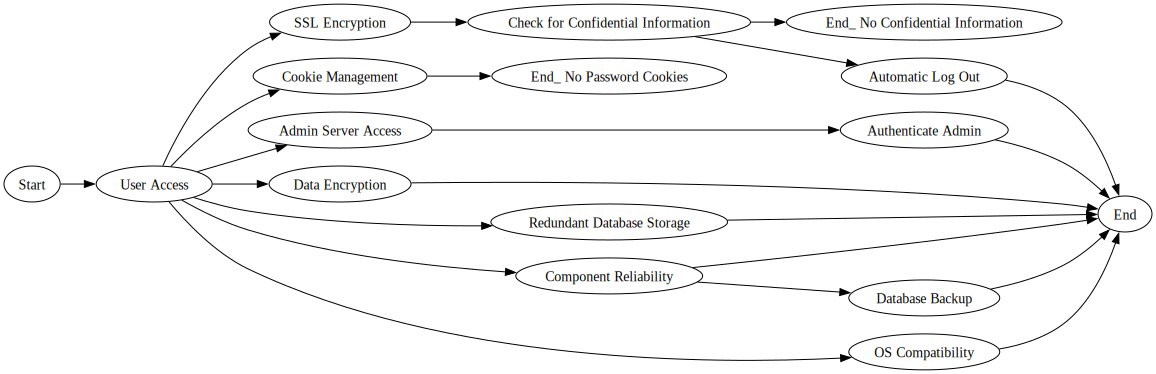

In [43]:
print(f"Project {project_id} Ground Truth:")
render_graph(ground_truth_nodes)

Project 34 Generated Graph:


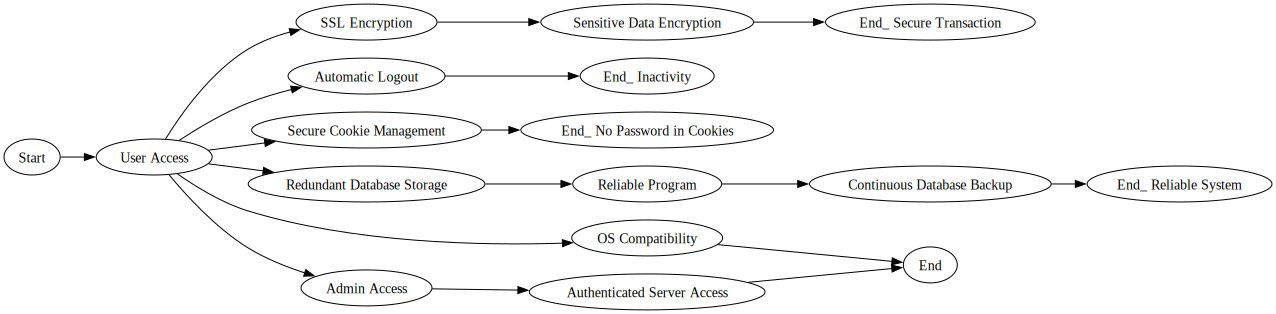

In [44]:
print(f"Project {project_id} Generated Graph:")
render_graph(generated_nodes)

#### Analysis:

**Observation** - There are many nodes where the semantic meaning is similar between the ground truth and generated graph. It may not be possible for the LLM to match the ground truth word-for-word due to the stochastic nature in which LLMs generate information.

**Suggested Resolution** - In this work, as long as the cosine similarity score between two embeddings is more than 0.8, the embeddings are considered a semantic match. Through acquiring a much large training set, this value (0.8) needs to be adjusted to further improve the performance of the system.

**Observation** - There are significant structural differences between the ground truth graph and the generated graph, for example the use of terminal 'end' nodes. 

**Suggested Resolution** - In creating the hand annotated set, deliberate rules should be followed to ensure that the training set adheres to a consistent standard. The prompt should also be updated to be deliberate in how certain structures (for example, having only 1 end node) should be followed in the graph. Furthermore additional metrics should be added to check how well the structures of the ground truth and generated graphs compare.